In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 11 - Signal detection theory
  
The basic data for an SDT analysis are  the counts of hits, false alarms, misses, and correct rejections. It is common to consider just the hit and false alarm counts which, together with the total number of signal and noise trials, completely describe the data.

|                  |   Signal trial   |   Noise trial    |
|:----------------:|:----------------:|:----------------:|
| Yes response     |        Hit       |   False alarm    |
| No response      |       Miss       |Correct rejection | 

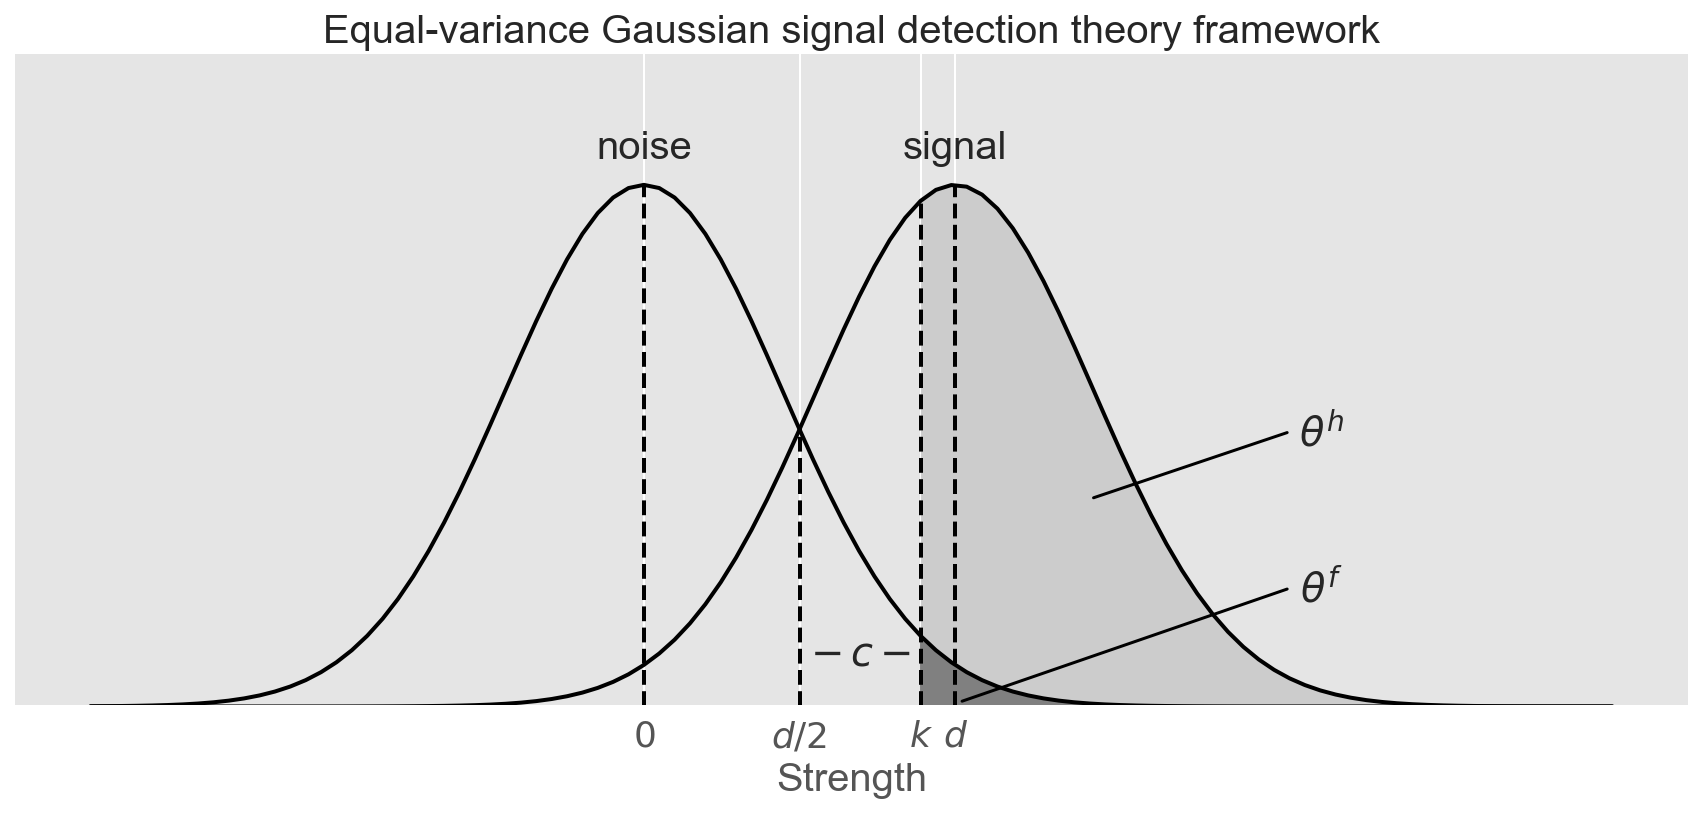

In [2]:
from matplotlib.patches import Polygon

func = stats.norm.pdf

a, b, d = 2, 7, 2.25  # integral limits 1
x = np.linspace(-4, b, 100)
y = func(x)
y2 = func(x, loc=d)

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(x, y, 'k', linewidth=2)
plt.plot(x, y2, 'k', linewidth=2)
d2 = x[y==y2]

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
iy2 = func(ix, loc=d)

verts = [(a, 0)] + list(zip(ix, iy2)) + [(b, 0)]
poly = Polygon(verts, facecolor='.8', edgecolor='1')
ax.add_patch(poly)

verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='.5', edgecolor='0.5')
ax.add_patch(poly)

plt.text(0, y.max()+.02, "noise",
         horizontalalignment='center', fontsize=20)
plt.text(d, y.max()+.02, "signal",
         horizontalalignment='center', fontsize=20)
plt.text((d/2+a)/2, y.max()*.08, r"$ - \,c - $",
         horizontalalignment='center', fontsize=20)
plt.text(b*.7, y.max()*.5, r"$\theta^h$",
         horizontalalignment='center', fontsize=20)
plt.text(b*.7, y.max()*.2, r"$\theta^f$",
         horizontalalignment='center', fontsize=20)
plt.plot([d+1, b*.7-.25], [y.max()*.4, y.max()*.5+.01], color='k', linestyle='-', linewidth=1.5)
plt.plot([d+.05, b*.7-.25], [y.max()*.01, y.max()*.2+.01], color='k', linestyle='-', linewidth=1.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

plt.plot([0, 0], [0, func(0)], color='k', linestyle='--', linewidth=2)
plt.plot([d/2, d/2], [0, func(d/2)], color='k', linestyle='--', linewidth=2)
plt.plot([a, a], [0, func(a, loc=d)], color='k', linestyle='--', linewidth=2)
plt.plot([d, d], [0, func(d, loc=d)], color='k', linestyle='--', linewidth=2)

ax.set_xticks((0, a, d, d/2))
ax.set_xticklabels(('$0$', '$k$', '$d$', '$d/2$'), fontsize=18)
ax.set_yticks([])
plt.ylim(0, y.max()+.1)
plt.title('Equal-variance Gaussian signal detection theory framework', fontsize=20)
plt.xlabel('Strength', fontsize=20)
plt.show()

## 11.1 Signal detection theory


$$ d_{i} \sim \text{Gaussian}(0,\frac{1}{2})$$
$$ c_{i} \sim \text{Gaussian}(0,2)$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 19.467:   5%|▌         | 10580/200000 [00:01<00:17, 10558.29it/s]
Convergence archived at 11400
Interrupted at 11,400 [5%]: Average Loss = 31.318
100%|██████████| 10500/10500.0 [00:18<00:00, 568.40it/s]


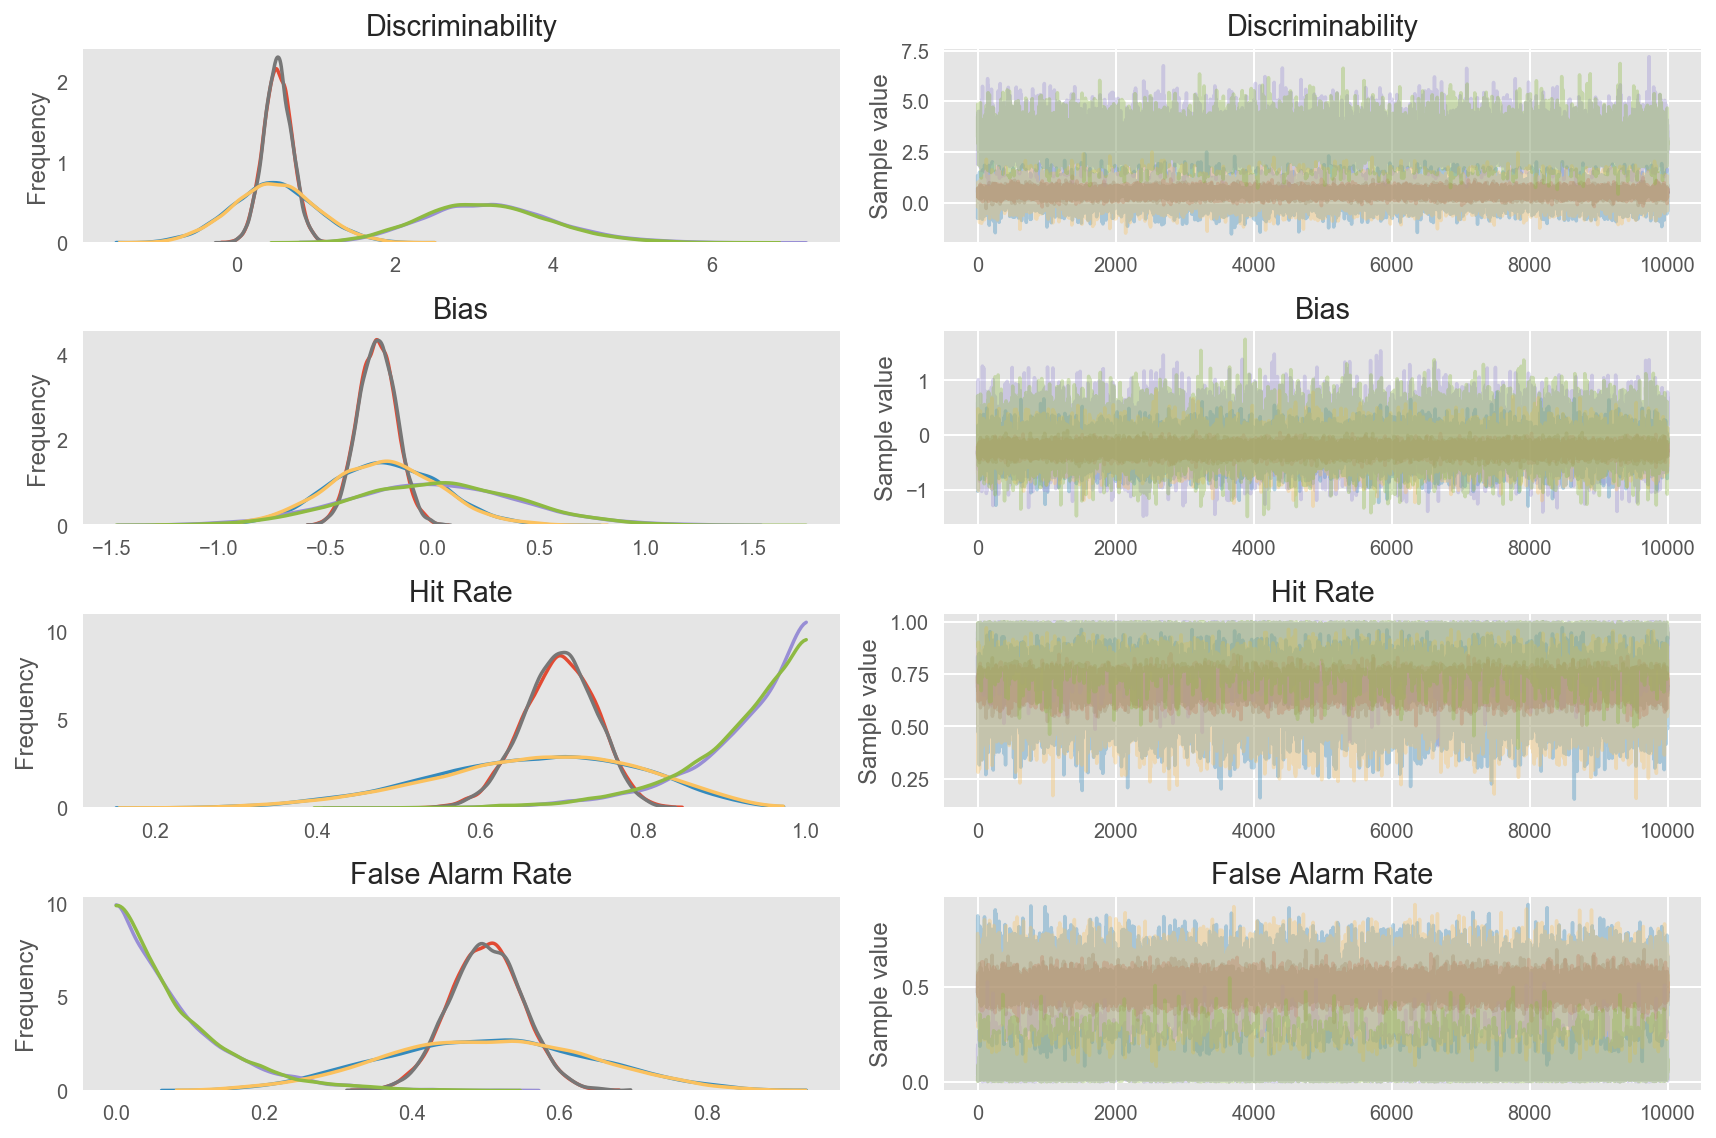

In [3]:
# Load data
dataset = 1
if dataset==1:  # Demo
    k = 3 # number of cases
    data =np.array([70, 50, 30, 50,
                    7,  5,  3,  5, 
                    10,  0,  0, 10]).reshape(k, -1)
else:  # Lehrner et al. (1995) data 
    k = 3 # number of cases
    data =np.array([148, 29, 32, 151,
                    150, 40, 30, 140,
                    150, 51, 40, 139]).reshape(k, -1)
    
h  = data[:, 0]
f  = data[:, 1]
MI = data[:, 2]
CR = data[:, 3]
s = h + MI
n = f + CR

def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + tt.erf(x / tt.sqrt(2.0))) / 2.0
    
with pm.Model() as model1:
    di = pm.Normal('Discriminability', mu=0, tau=.5, shape= k)
    ci = pm.Normal('Bias', mu=0, tau=2, shape= k)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))
    
    hi = pm.Binomial('hi',p=thetah,n=s,observed=h)
    fi = pm.Binomial('fi',p=thetaf,n=n,observed=f)
    trace1=pm.sample(1e4, njobs=2)

burnin=0    
pm.traceplot(trace1[burnin:], 
             varnames=['Discriminability', 'Bias', 'Hit Rate', 'False Alarm Rate']);

## 11.2 Hierarchical signal detection theory
  
$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ d_{i} \sim \text{Gaussian}(\mu_{d},\lambda_{d})$$
$$ c_{i} \sim \text{Gaussian}(\mu_{c},\lambda_{c})$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [4]:
# Load data using rpy2
from rpy2 import *
%load_ext rpy2.ipython
%R source("data/heit_rotello.RData") -o std_i -o std_d 
# the induction data and the deduction data

h1  = np.array(std_i['V1'])
f1  = np.array(std_i['V2'])
MI1 = np.array(std_i['V3'])
CR1 = np.array(std_i['V4'])
s1 = h1 + MI1
n1 = f1 + CR1

h2  = np.array(std_d['V1'])
f2  = np.array(std_d['V2'])
MI2 = np.array(std_d['V3'])
CR2 = np.array(std_d['V4'])
s2 = h2 + MI2
n2 = f2 + CR2

k=len(h1)

In [5]:
with pm.Model() as model2i:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    
    di = pm.Normal('di', mu=mud, tau=lambdad, shape= k)
    ci = pm.Normal('ci', mu=muc, tau=lambdac, shape= k)

    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s1, observed=h1)
    fi = pm.Binomial('fi', p=thetaf, n=n1, observed=f1)
    trace_i=pm.sample(3e3, njobs=2)
    
with pm.Model() as model2d:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    
    di = pm.Normal('di', mu=mud,tau=lambdad,shape= k)
    ci = pm.Normal('ci', mu=muc,tau=lambdac, shape= k)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s2, observed=h2)
    fi = pm.Binomial('fi', p=thetaf, n=n2, observed=f2)
    trace_d=pm.sample(3e3, njobs=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 123.86:   8%|▊         | 15478/200000 [00:06<00:44, 4189.24it/s]
Convergence archived at 15800
Interrupted at 15,800 [7%]: Average Loss = 154.14
100%|█████████▉| 3486/3500.0 [00:25<00:00, 148.29it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 63 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 3500/3500.0 [00:25<00:00, 137.82it/s]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 1 contains 46 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 115.07:  11%|█         | 214

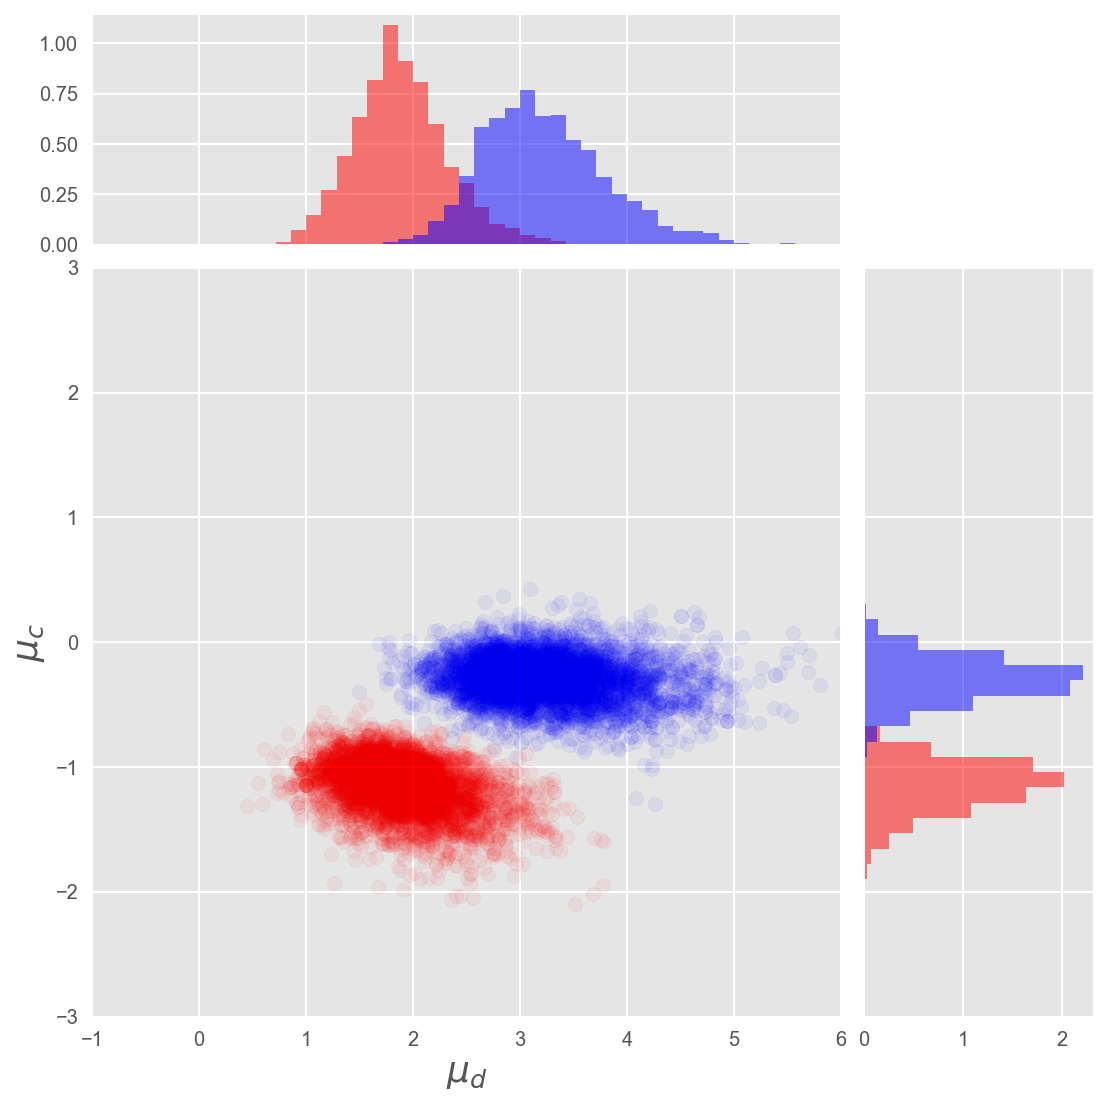

In [6]:
def scatterplot_2trace(trace1, trace2):
    from matplotlib.ticker import NullFormatter
    nullfmt = NullFormatter()         # no labels

    burnin=500 # set to zero to plot the one without burnin

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # now determine limits by hand:
    binwidth1 = 0.25

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    cc = np.array([[1,0,0],[0,0,1]])

    for idd in np.arange(2):
        if idd==0:
            x = trace1['mud'][burnin:]
            y = trace1['muc'][burnin:]
        else:
            x = trace2['mud'][burnin:]
            y = trace2['muc'][burnin:]

        axScatter = plt.axes(rect_scatter)
        axScatter.set_xlim((-1, 6))
        axScatter.set_ylim((-3, 3))

        axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)

        # the scatter plot:
        axScatter.scatter(x, y,c=cc[idd,:],alpha=.05)
        axScatter.set_xlabel(r'$\mu_d$',fontsize=18)
        axScatter.set_ylabel(r'$\mu_c$',fontsize=18)

        bins1 = np.linspace(-1, 6, 50)
        axHistx.hist(x, bins=bins1,color=cc[idd,:],alpha=.5,normed=True)
        bins2 = np.linspace(-3, 3, 50)
        axHisty.hist(y, bins=bins2, color=cc[idd,:],alpha=.5,normed=True, orientation='horizontal')

        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())

    plt.show()

scatterplot_2trace(trace_i, trace_d)

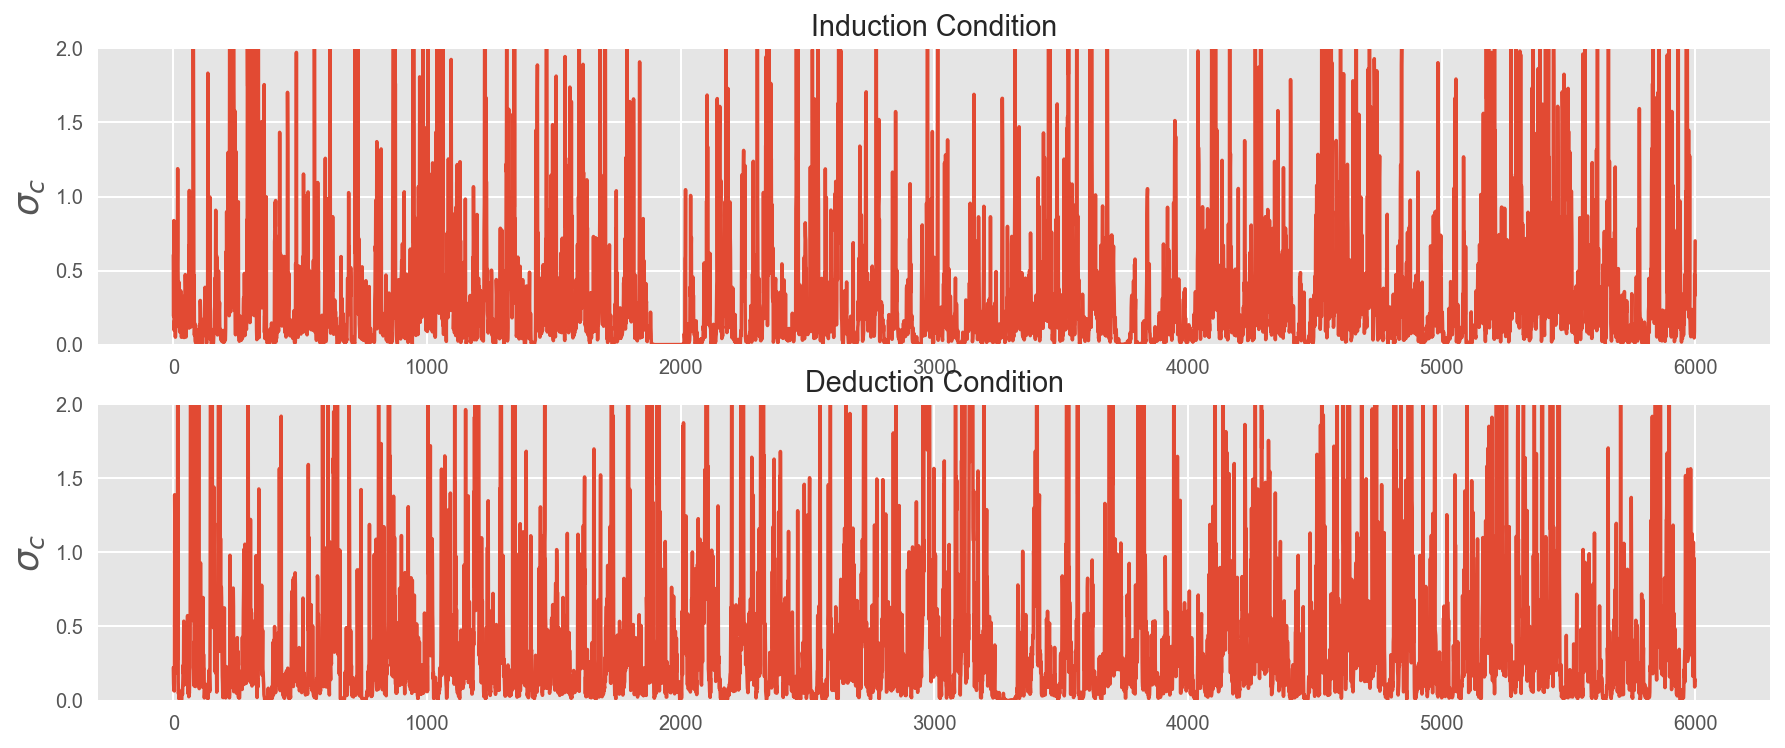

In [7]:
tmptrace = trace_i['lambdac'][:]
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2,1)
plt.subplot(gs[0])
plt.plot(1/tmptrace**2)
plt.ylim(0,2)
plt.title('Induction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.subplot(gs[1])
tmptrace = trace_d['lambdac'][:]
plt.plot(1/tmptrace**2)
plt.ylim(0,2)
plt.title('Deduction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.show()

## 11.3 Parameter expansion
  
  
Using parameter expansion to escape the "zero variance trap" in MCMC sampling.  

$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ \xi_{d},\xi_{c} \sim \text{Beta}(1,1)$$
$$ \delta_{d_{i}} \sim \text{Gaussian}(0,\lambda_{d})$$
$$ \delta_{c_{i}} \sim \text{Gaussian}(0,\lambda_{c})$$
$$ \sigma_{d} = \lvert \xi_{d}\rvert\,/\,\sqrt\lambda_{d}$$
$$ \sigma_{c} = \lvert \xi_{c}\rvert\,/\,\sqrt\lambda_{c}$$
$$ d_{i} = \mu_{d} + \xi_{d}\delta_{d_{i}}$$
$$ c_{i} = \mu_{c} + \xi_{c}\delta_{c_{i}}$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [8]:
with pm.Model() as model3i:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    xid = pm.Uniform('xid', lower=0, upper=1)
    xic = pm.Uniform('xic', lower=0, upper=1)
    deltadi = pm.Normal('deltadi', mu=0, tau=lambdad, shape=k)
    deltaci = pm.Normal('deltaci', mu=0, tau=lambdac, shape=k)
    
    sigmad = pm.Deterministic('sigmad', xid/tt.sqrt(lambdad))
    sigmac = pm.Deterministic('sigmac', xic/tt.sqrt(lambdac))
    
    di = pm.Deterministic('di', mud+xid*deltadi)
    ci = pm.Deterministic('ci', muc+xic*deltaci)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s1, observed=h1)
    fi = pm.Binomial('fi', p=thetaf, n=n1, observed=f1)
    trace_i2=pm.sample(3e3, njobs=2)
    
with pm.Model() as model3d:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    xid = pm.Uniform('xid', lower=0, upper=1)
    xic = pm.Uniform('xic', lower=0, upper=1)
    deltadi = pm.Normal('deltadi', mu=0, tau=lambdad, shape=k)
    deltaci = pm.Normal('deltaci', mu=0, tau=lambdac, shape=k)
    
    sigmad = pm.Deterministic('sigmad', xid/tt.sqrt(lambdad))
    sigmac = pm.Deterministic('sigmac', xic/tt.sqrt(lambdac))
    
    di = pm.Deterministic('di', mud+xid*deltadi)
    ci = pm.Deterministic('ci', muc+xic*deltaci)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s2, observed=h2)
    fi = pm.Binomial('fi', p=thetaf, n=n2, observed=f2)
    trace_d2=pm.sample(3e3, njobs=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 126.2:   7%|▋         | 14314/200000 [00:03<00:38, 4835.12it/s] 
Convergence archived at 14700
Interrupted at 14,700 [7%]: Average Loss = 147.91
 91%|█████████▏| 3200/3500.0 [00:57<00:07, 41.36it/s] /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.659732384345, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 1 contains 164 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 3498/3500.0 [01:04<00:00, 44.91it/s]/Library/Frameworks/Python.framework/Versions/3.5/li

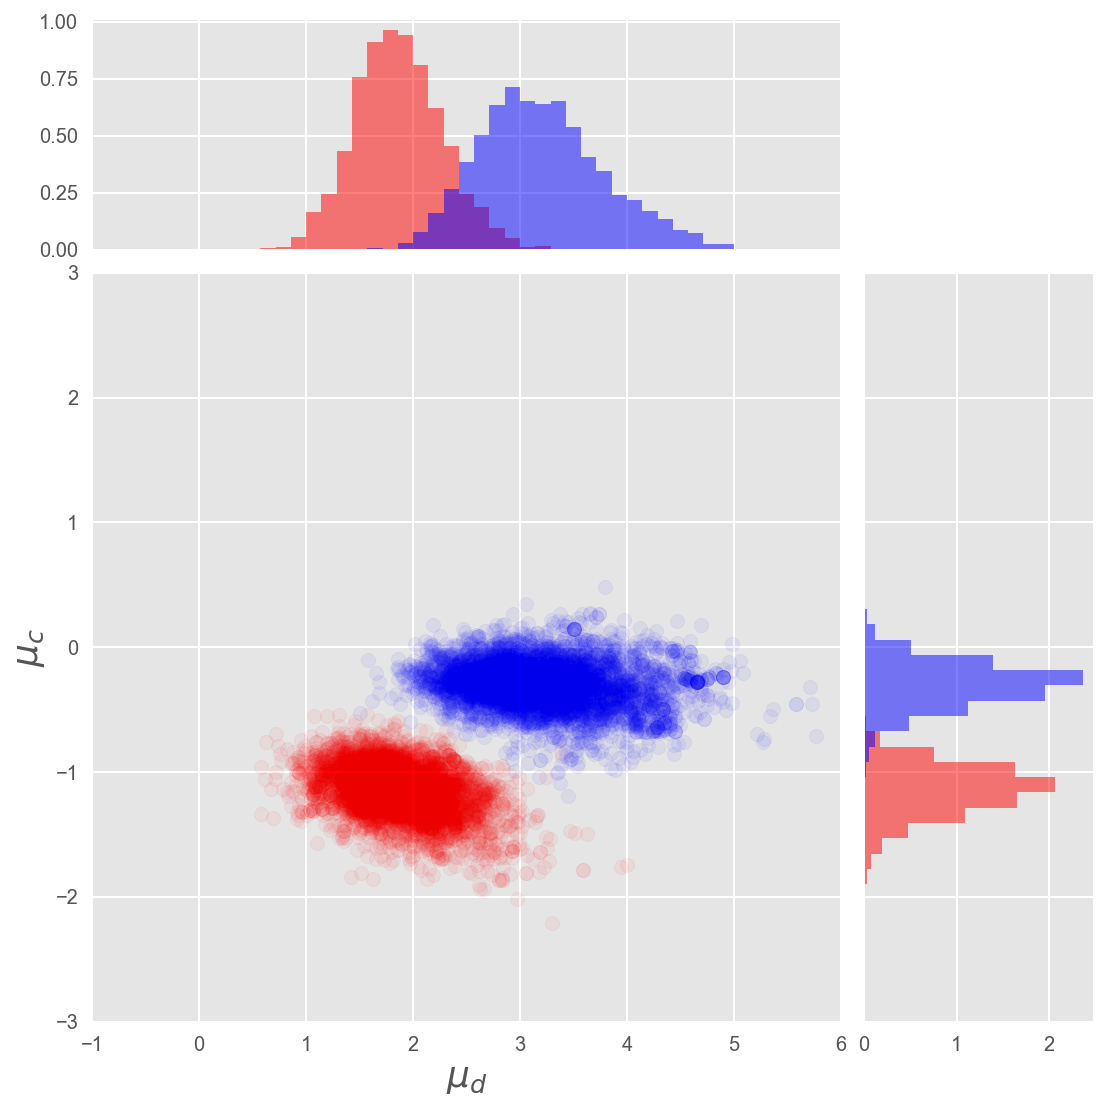

In [9]:
scatterplot_2trace(trace_i2, trace_d2)

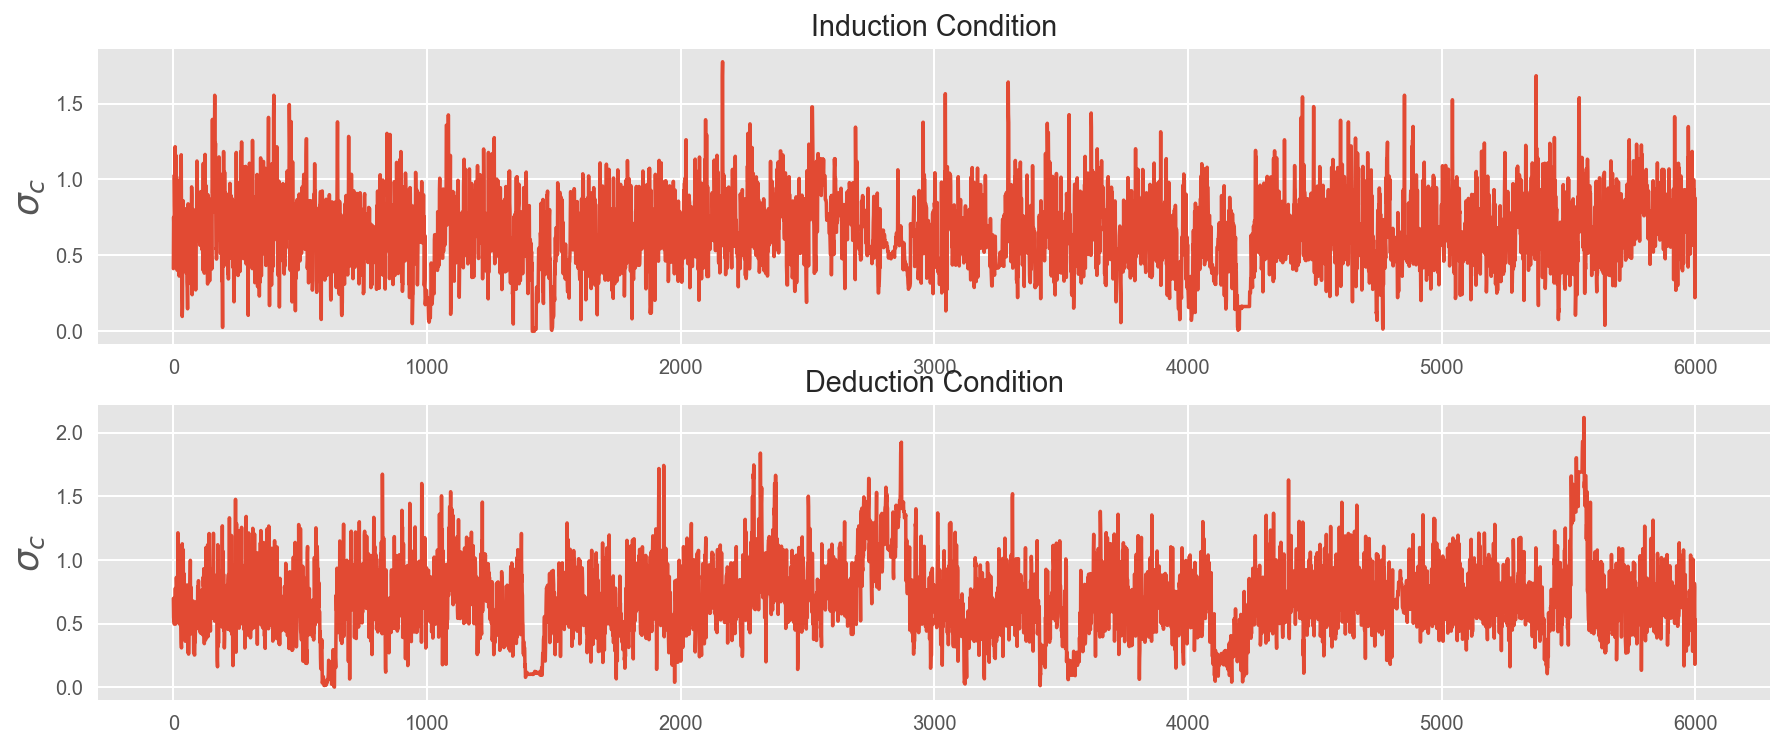

In [10]:
tmptrace = trace_i2['sigmac'][:]
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2,1)
plt.subplot(gs[0])
plt.plot(tmptrace)

plt.title('Induction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.subplot(gs[1])
tmptrace = trace_d2['sigmac'][:]
plt.plot(tmptrace)

plt.title('Deduction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.show()

# Additional:
Sampling using HMC (e.g., in STAN and PyMC3), there are better way to diagnose biased inference [[1]](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html), [[2]](http://pymc-devs.github.io/pymc3/notebooks/Diagnosing_biased_Inference_with_Divergences.html).

In [11]:
def plot_samplerstat(burnin, trace):
    # Sampler statistics
    accept = trace.get_sampler_stats('mean_tree_accept', burn=burnin)
    print('The accept rate is: %.5f' % (accept.mean()))
    diverge = trace.get_sampler_stats('diverging')
    print('Diverge of the trace')
    print(diverge.nonzero())
    energy = trace['energy']
    energy_diff = np.diff(energy)
    sns.distplot(energy - energy.mean(), label='energy')
    sns.distplot(energy_diff, label='energy diff')
    plt.legend()
    plt.show()

The accept rate is: 0.78005
Diverge of the trace
(array([ 237,  238,  241,  730,  869,  900, 1042, 1043, 1060, 1098, 1100,
       1202, 1471, 1601, 1894, 1896, 1899, 1900, 1901, 1902, 1906, 1907,
       1908, 1914, 1915, 1918, 1919, 1920, 1921, 1922, 1923, 1927, 1932,
       1938, 1941, 1943, 1947, 1950, 1954, 1957, 1960, 1961, 1967, 1968,
       1973, 1980, 1987, 1995, 2109, 2115, 2158, 2337, 2354, 2461, 2464,
       2527, 2595, 2624, 2628, 2710, 2779, 2842, 2991, 3012, 3101, 3268,
       3269, 3433, 3434, 3439, 3523, 3528, 3619, 3731, 3737, 3738, 3745,
       3753, 3759, 3837, 3897, 4042, 4107, 4264, 4535, 4598, 4714, 4878,
       4994, 5113, 5176, 5178, 5179, 5182, 5183, 5184, 5185, 5186, 5188,
       5191, 5192, 5194, 5236, 5400, 5450, 5509, 5714, 5828, 5967]),)


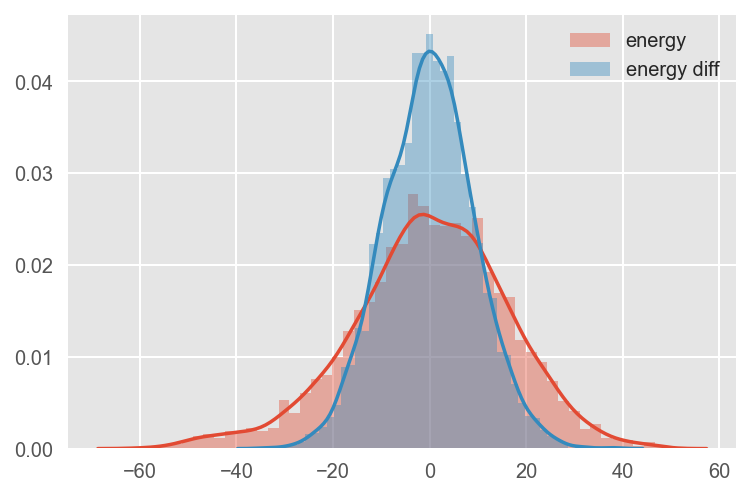

In [12]:
plot_samplerstat(2000, trace_i)

The accept rate is: 0.83864
Diverge of the trace
(array([   3,    4,   73,   78,   81,   83,  148,  149,  151,  152,  153,
        179,  188,  398,  535,  642,  647,  648,  852,  886, 1190, 1196,
       1201, 1289, 1292, 1344, 1379, 1463, 1504, 1510, 1511, 1597, 1727,
       1728, 1729, 2007, 2199, 2241, 2284, 2321, 2322, 2324, 2325, 2326,
       2396, 2397, 2676, 2805, 2847, 2916, 2935, 2937, 2961, 2964, 2965,
       2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 3087,
       3088, 3114, 3115, 3116, 3135, 3137, 3138, 3139, 3140, 3142, 3143,
       3144, 3145, 3146, 3147, 3149, 3150, 3151, 3388, 3390, 3518, 3523,
       3620, 3703, 3704, 3708, 3715, 3722, 3811, 3826, 3827, 4157, 4160,
       4161, 4166, 4170, 4281, 4291, 4573, 4626, 4627, 4703, 4706, 4707,
       4741, 4851, 4865, 4930, 4963, 4973, 4974, 5097, 5215, 5221, 5222,
       5223, 5226, 5233, 5239, 5369, 5460, 5586, 5828, 5832, 5841, 5879,
       5881, 5883, 5884, 5886, 5887, 5888, 5891, 5892, 5893, 5962, 5986]),

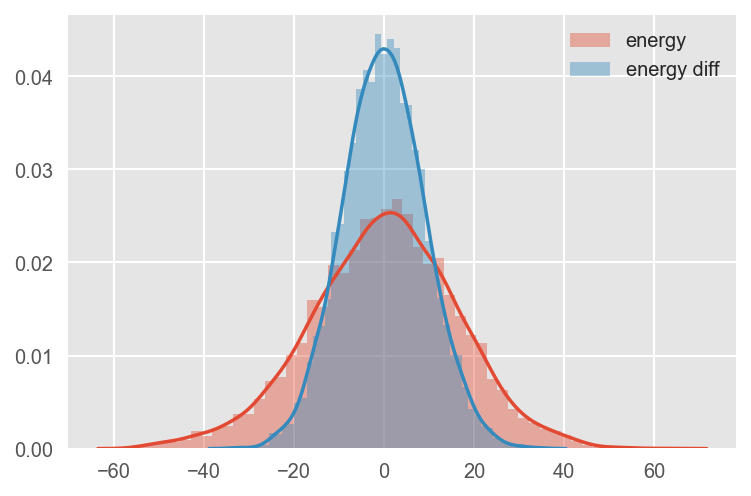

In [13]:
plot_samplerstat(2000, trace_d)

The accept rate is: 0.53292
Diverge of the trace
(array([  28,  150,  159,  160,  161,  162,  163,  173,  183,  205,  206,
        214,  223,  242,  245,  270,  278,  290,  298,  369,  370,  372,
        374,  394,  401,  413,  414,  417,  455,  456,  463,  515,  525,
        636,  801,  815,  818,  905,  928,  932,  957,  958,  960,  964,
        966,  970,  973,  975,  976,  977,  978,  979,  980,  981,  982,
        983,  984,  985,  986,  988,  993,  995,  998, 1002, 1003, 1004,
       1007, 1010, 1011, 1012, 1016, 1028, 1033, 1034, 1035, 1037, 1043,
       1047, 1050, 1051, 1052, 1053, 1054, 1055, 1062, 1064, 1067, 1068,
       1078, 1083, 1085, 1112, 1223, 1226, 1236, 1264, 1281, 1313, 1517,
       1525, 1530, 1536, 1742, 1749, 1756, 1764, 1805, 1848, 1852, 1853,
       1919, 1926, 1941, 2058, 2095, 2166, 2206, 2218, 2248, 2263, 2266,
       2268, 2330, 2341, 2346, 2350, 2352, 2361, 2363, 2364, 2375, 2376,
       2377, 2387, 2393, 2394, 2395, 2396, 2397, 2398, 2400, 2402, 2410,
 

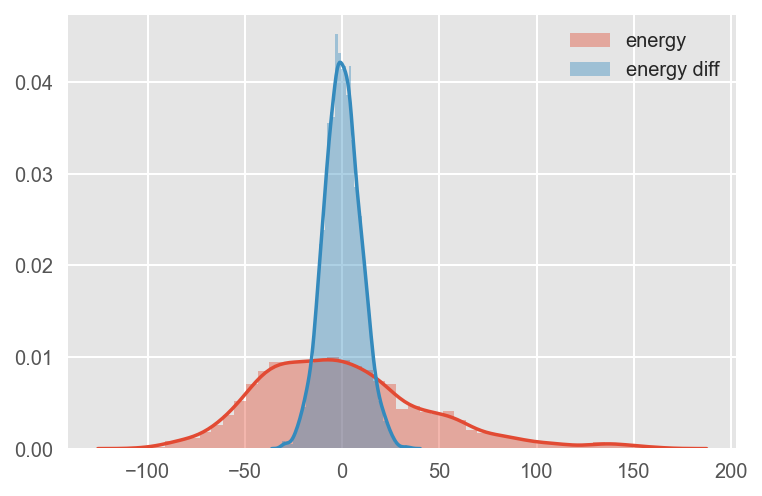

In [14]:
plot_samplerstat(2000, trace_i2)

The accept rate is: 0.53036
Diverge of the trace
(array([   7,   21,   41, ..., 5943, 5948, 5949]),)


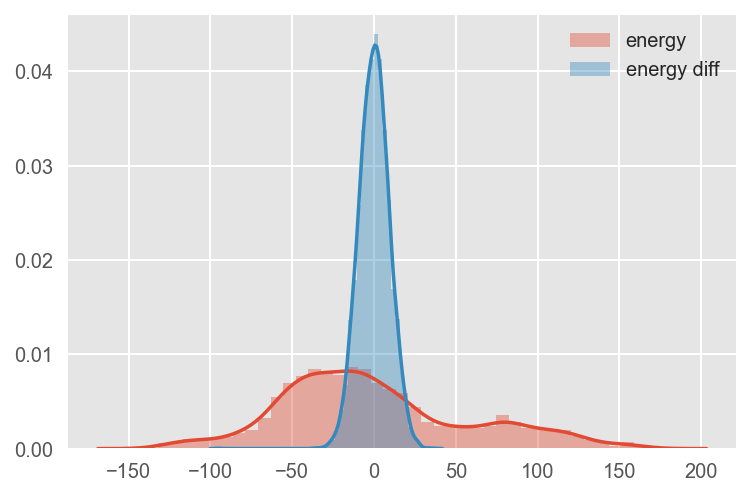

In [15]:
plot_samplerstat(2000, trace_d2)

As shown above, there are a lot of divergences in the trace, and the energy plot is very different from the energy_diff. This is a strong indication of bias in the estimation, and better reparameterization is needed.

Moreover, the reparameterization, which works better in BUGS/JAGS using Gibbs sampler, actually perform worse using NUTS. Again, this demonstrates that many of the tricks and intuition we got using BUGS/JAGS might not translate to PyMC3 and STAN.